## Introduction

A partir d'un dataset, nous allons réaliseré une prédiction des profils dont le métier n'est pas labellisé.


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


Le nombre d'observations est 9582. On voit qu'il y des valeurs manquantes pour plusieurs varables. Mais le nombre des valeaurs manquantes est insignifiant par rapport au nombre total.

In [5]:
df.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

### La variable Expérience

Réalisons l'imputation des valeurs manquantes pour la variable "Experience".

In [6]:
df['Experience'].unique()

array(['1', '3', '1,5', nan, '6', '0', '4', '8', '5', '0,5', '2', '3,5',
       '9', '7', '2,5', '13', '17', '12', '10', '11', '15', '21'],
      dtype=object)

In [7]:
df['Experience'] = df['Experience'].str.replace(',','.')

In [8]:
df['Experience'] = pd.to_numeric(df['Experience'])

In [9]:
# Imputer les valeurs manquants par le moyen.
df.fillna({'Experience' : round(df['Experience'].mean(),0)}, inplace=True)

In [10]:
df['Experience'].isna().sum()

0

Combien d'années d'expériences ont, en moyenne, chacun des profils?

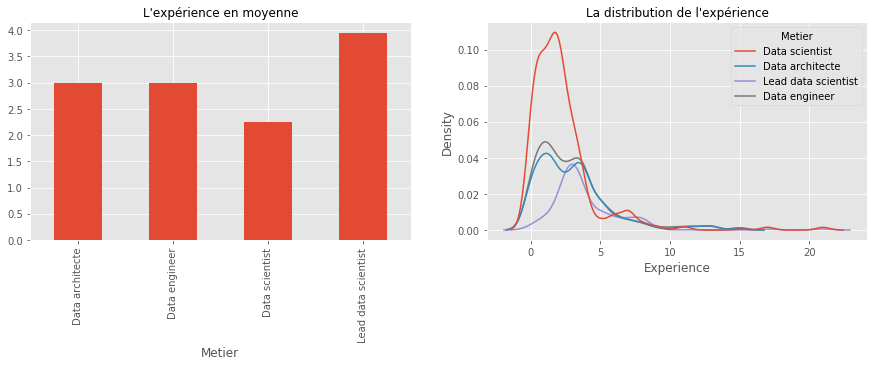

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
df.groupby('Metier').mean()['Experience'].plot.bar(ax=axes[0])
axes[0].set_title("L'expérience en moyenne", fontsize=12)
sb.kdeplot(data=df, x='Experience', hue='Metier', ax=axes[1])
axes[1].set_title("La distribution de l'expérience", fontsize=12);

L'éxperience en moyenne est égale 3 ans chez data architecte et data engineer. Lead data scientist ont en moyenne 4 ans d'expérience et data scientist 2,2 ans. La variable 'Experience' est une variable ordinal, transformons en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert.  

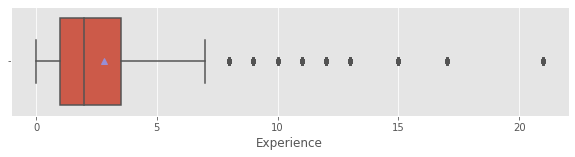

In [12]:
fig, ax = plt.subplots(figsize=(10,2))
sb.boxplot(x='Experience', showmeans=True, data=df, ax=ax)
plt.show()

In [13]:
df['Exp_label'] = pd.cut(df['Experience'], bins=[0,2.5,4,7,30], right=False,
                  labels=['Debutant', 'Confirme', 'Avance', 'Expert'])

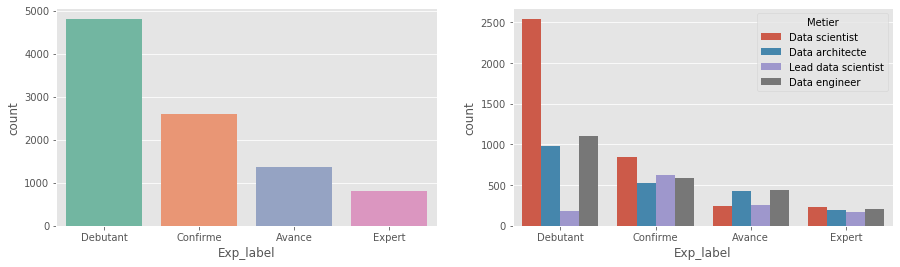

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
sb.countplot(x='Exp_label', data=df, ax=axes[0], palette='Set2', 
             order=df['Exp_label'].value_counts().index)
sb.countplot(x='Exp_label', hue='Metier', data=df, ax=axes[1],
             order=df['Exp_label'].value_counts().index)
plt.show()

### La variable Technologie

Cherchons 5 technologies les plus utilisées.

In [15]:
#df.head()

In [16]:
# Une liste qui contients toutes les technologies.
A = []
for i in range(len(df)):
    A.extend(map(str.lower, df.iloc[i,2].split('/')))

values, counts = np.unique(A, return_counts=True)

In [17]:
values

array(['', 'ai', 'anglais', 'aws', 'big data', 'c', 'c++', 'cassandra',
       'deep learning', 'docker', 'elasticsearch', 'excel', 'gnu',
       'hadoop', 'hadoop(hdfs)', 'hbase', 'hdfs', 'hive', 'java', 'kafka',
       'kibana', 'linux', 'machine learning', 'map-reduce', 'mariadb',
       'matlab', 'matplotlib', 'microsoft azure', 'mongodb', 'mysql',
       'nosq', 'nosql', 'numpy', 'oracle', 'perl', 'pig', 'postgresql',
       'pycharm', 'pyspark', 'python', 'r', 'redshift', 'ruby', 'sas',
       'scala', 'scikit-learn', 'scoring', 'spark', 'spss', 'sql',
       'tableau', 'tensorflow', 'teradata', 'vba', 'vertica', 'windows',
       'yarn'], dtype='<U16')

In [18]:
# Dataframe de technologie, nombre de candidads et 
# pourcentage de candidads qui maîtrisent la technologie.
df_tech = pd.DataFrame(
        {
            'Technologie': values[1:], # commencer par index 1 pour exclure l'espace vide 
            'Nombre': counts[1:],
            'Pourcentage %': [round(100*i/len(df)) for i in counts[1:]]
        }
)
#Trions selon le "Nombre".
df_tech = df_tech.sort_values(by='Nombre', ascending=False).reset_index(drop=True)

In [19]:
df_tech.head(5)

,Technologie,Nombre,Pourcentage %
0,python,6627,69.0
1,r,4374,46.0
2,sql,2581,27.0
3,java,1719,18.0
4,hadoop,1589,17.0


Les 5 technologies les plus utilisées sont Python, R, SQL, Java, Hadoop.

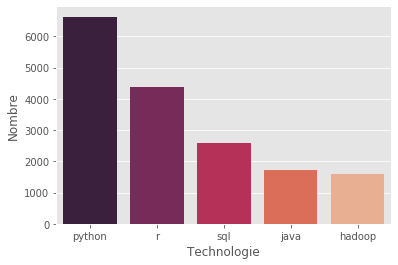

In [20]:
sb.barplot(x="Technologie", y="Nombre", palette = "rocket", data = df_tech[:5]);

In [21]:
len(df['Ville'].unique())

14

In [22]:
len(df['Entreprise'].unique())

1383

La variable 'Entreprise' n'est pas une variable pertinant pour clustering des profils techniques distinctes et classification des métiers.

In [23]:
df_ = df.drop('Entreprise', axis=1).copy()

Pour exploiter la variable "Technologies" nous allons la transformer en plusieurs variables indicatrices.

In [24]:
# Ajouter des nouvelles colonnes à data qui correspondent, aux technologies. 
# Ces colonnes sont composés de 0 et 1. 0 si l'individu ne maîtrise pas 
# la technologie.

df_num = df_.copy()
for j in df_tech['Technologie']: # l'ensemble de technologies
    df_num[j] = df_num['Technologies'].apply(lambda x: 1 if j in x.lower() else 0)

In [25]:
df_num[:3]

,Metier,Technologies,Diplome,Experience,Ville,Exp_label,python,r,sql,java,...,hbase,numpy,redshift,nosq,hadoop(hdfs),oracle,mysql,windows,perl,ruby
0,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,Debutant,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,Confirme,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,Confirme,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Preparons les donner pour clustering et classification.

In [26]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_num = df_num.drop(['Technologies','Exp_label'], axis=1)
df_num['Experience'] = scaler.fit_transform(df_num[['Experience']].values)
# Transformer en dummies les autres variables.
df_num = pd.get_dummies(data=df_num, columns=['Diplome', 'Ville'])

In [27]:
#df_num.info()

### La prédiction des métiers manquants dans la base de données  

In [28]:
print('Les pourcentages de métiers')
print('')
print(round(df['Metier'].value_counts()/len(df)*100,1))

Les pourcentages de métiers

Data scientist         40.3
Data engineer          24.5
Data architecte        22.2
Lead data scientist    12.8
Name: Metier, dtype: float64


Un problème multi-label avec un modéré déséquilibre de classes. De plus on a vue que les classes 'Data engineer' et 'Data architecte' ont des caractérisques très similaires, master et 3 ans d'expérience en moyenne. Ceci nous dit que les résultats ne seront pas prometteurs.

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Choisir les données pour entraîner le modèle.
x_train = df_num.dropna().drop('Metier', axis=1)
y_train = le.fit_transform(df_num.dropna()['Metier'].astype(str))

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=42)

Comparons les performances de divers modèles.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [32]:
classifiers = {
    "Logisitic Regression": LogisticRegression(max_iter=300),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier()
}

In [33]:
for key, classifier in classifiers.items():
    classifier.fit(x_train.values, y_train)
    training_score = cross_val_score(classifier, x_train.values, y_train, cv=5)
    print(classifier.__class__.__name__, "a un score de training de"
 , round(training_score.mean(), 1) * 100, "% score de précision")

LogisticRegression a un score de training de 90.0 % score de précision
SVC a un score de training de 90.0 % score de précision
DecisionTreeClassifier a un score de training de 90.0 % score de précision
RandomForestClassifier a un score de training de 90.0 % score de précision


On va chercher les meilleurs paramètres pour Random Forest.

#Utiliser RandomizedSearchCV pour trouver les meillieurs parametres.
from sklearn.model_selection import RandomizedSearchCV

#Random forest
random_grid = {'n_estimators': [100, 200, 400, 500, 600, 700],
              'bootstrap': [True, False],
              'max_features': ['log2','sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 20],
              'min_samples_split': [2, 5, 10, 20, 30],
              'min_samples_leaf': [1, 2, 4]
              }

rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid,
                n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train.values, y_train)

rf = rf_random.best_estimator_

rf

In [34]:
# Classifier avec les paramètres trouvé dans l'étape précedant.
cl = RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=4,
                            min_samples_split=30, n_estimators=500)

In [35]:
cl.fit(x_train.values, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=4,
                       min_samples_split=30, n_estimators=500)

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = cl.predict(x_test.values)

cm = confusion_matrix(y_test, y_pred)

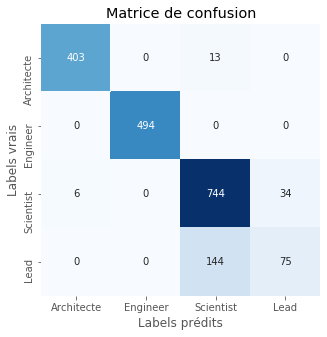

In [37]:
f, ax = plt.subplots(1,1, figsize=(5,5))
sb.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax, cbar=False)
ax.set_xlabel('Labels prédits')
ax.set_ylabel('Labels vrais') 
ax.set_title('Matrice de confusion') 
ax.xaxis.set_ticklabels(['Architecte', 'Engineer', 'Scientist', 'Lead']) 
ax.yaxis.set_ticklabels(['Architecte', 'Engineer', 'Scientist', 'Lead']);

In [38]:
target_names = ['Architecte', 'Engineer', 'Scientist', 'Lead']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Architecte       0.99      0.97      0.98       416
    Engineer       1.00      1.00      1.00       494
   Scientist       0.83      0.95      0.88       784
        Lead       0.69      0.34      0.46       219

    accuracy                           0.90      1913
   macro avg       0.87      0.82      0.83      1913
weighted avg       0.89      0.90      0.88      1913



* Recall scores ($\frac{TP}{TP+FN}$) pour data architecte, data engineer et data scientist sont $0,97$, $1$ et $0,95$. Recall score pour lead data scientist est très bas $0,33$. 

* Ceci explique pour deux raisons, l'une que lead data scietnist est la classe minoritaire seulement $12\%$ des donné. Deuxiemement on voit sur la matrice de confusion que tous les fauts negatives pour la classe lead data scientist sont fauts positive pour data scientist. Le model dissocie mal ces deux classes et comme data scientist est la classe majoritaire il donne préference à data scientist.

* Notre modèle identifient très bien les architectes et engineers. 

* Pour la paramètre "class_weight" le mode "balanced" utilise les valeurs de "y" pour ajuster automatiquement les poids de manière inversement proportionnelle aux fréquences des classes. Nous pénalisons ainsi plus fortement une erreur de classification d’une classe minoritaire par rapport à une erreur de classification d’une classe majoritaire. Ainsi recall score pour lead data scientist va augmanter mais le score de précision va diminuer.

Maintenant réalisons la prédiction des métiers manquants dans la base de données par ce modèle.

In [39]:
X = df_num[df_num['Metier'].isna()].drop('Metier', axis=1)
df.loc[df['Metier'].isna(),'Metier'] = le.inverse_transform(cl.predict(X))

In [40]:
#df.head()